# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutoria](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [51]:
from scipy.optimize import brentq

from SALib.analyze import sobol

from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant,
                           ema_logging, MultiprocessingEvaluator, Policy, SequentialEvaluator)
from ema_workbench.em_framework.evaluators import SOBOL, LHS
from ema_workbench.em_framework import get_SALib_problem
from ema_workbench import Policy, perform_experiments

import pandas as pd

from SALib.analyze.sobol import analyze
from ema_workbench.analysis import feature_scoring

import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [61]:
policy = [Policy('0', **{l.name:0 for l in lake_model.levers}),
          Policy('0.05', **{l.name:0.05 for l in lake_model.levers}),
          Policy('0.1', **{l.name:0.1 for l in lake_model.levers})]

In [7]:
n_scenarios = 1000

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policy,
                                            uncertainty_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
experiments_sobol, outcomes_sobol = results

In [9]:
problem = get_SALib_problem(lake_model.uncertainties)
y = outcomes_sobol['reliability']
sobol_indices = sobol.analyze(problem, y)

In [11]:
sobol_indices.to_df()[0]

,ST,ST_conf
b,0.469386,0.032928
delta,0.000010,0.000004
mean,0.118177,0.013754
q,0.300292,0.025453
stdev,0.000024,0.000010


## Analysing all policies using Sobol

In [12]:
sobol_results = {}

for policy in experiments_sobol.policy.unique():
    logical = experiments_sobol.policy == policy
    y = outcomes_sobol['reliability'][logical]
    indices = analyze(problem,y)
    sobol_results[policy] = indices

In [26]:
sobol_p0 = pd.concat([sobol_results['0'].to_df()[0],sobol_results['0'].to_df()[1]], axis = 1) 
sobol_p005 = pd.concat([sobol_results['0.05'].to_df()[0],sobol_results['0.05'].to_df()[1]], axis = 1) 
sobol_p01 = pd.concat([sobol_results['0.1'].to_df()[0],sobol_results['0.1'].to_df()[1]], axis = 1) 

In [30]:
sobol_p0.columns = ['ST0', 'ST_conf0', 'S10', 'S1_conf0']
sobol_p005.columns = ['ST005', 'ST_conf005', 'S1005', 'S1_conf005']
sobol_p01.columns = ['ST01', 'ST_conf01', 'S101', 'S1_conf01']

In [41]:
sobol_results_df = pd.concat([sobol_p0,sobol_p005,sobol_p01], axis = 1)
#sobol_results_df = sobol_results_df[['ST0', 'S10', 'ST005', 'S1005', 'ST01', 'S101']]

In [42]:
sobol_results_df

,ST0,ST_conf0,S10,S1_conf0,ST005,ST_conf005,S1005,S1_conf005,ST01,ST_conf01,S101,S1_conf01
b,0.715149,0.085924,0.360513,0.070029,0.752461,0.064505,0.532972,0.068742,0.829927,0.093216,0.392662,0.068157
delta,0.000030,0.000019,0.000221,0.000385,0.000013,0.000012,0.000354,0.000338,0.000006,0.000003,-0.000145,0.000256
mean,0.326005,0.053493,0.090242,0.047616,0.133742,0.029138,0.039429,0.035834,0.142992,0.044500,0.038777,0.030085
q,0.479945,0.062600,0.169561,0.068600,0.457849,0.050278,0.239283,0.059866,0.554692,0.095317,0.190987,0.058639
stdev,0.000064,0.000042,0.000247,0.000512,0.000023,0.000014,0.000455,0.000411,0.000043,0.000048,0.000332,0.000367


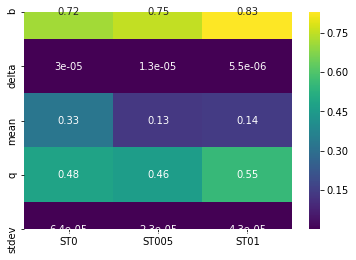

In [38]:
sns.heatmap(sobol_results_df[['ST0', 'ST005', 'ST01']], annot=True, cmap='viridis')

#### Conclusions

Total sensitivity
- The increase in release changes the sensitivity to each of the uncertainties, albiet very small. 
- Overall, the sensitivity increases to b
- The sensitivity to std deviation and q falls and rises again
- The sensitivity to mean and delta decreases

Individual Indices
- The individual indices don't show the same pattern 
- The interactiion effect has increased even if it is due to one uncertainty

The confidence intervals of all the policies remain similar to each other. It is possible that the sensitivities don't change drastically because the release does not change a lot across these policies. 

The change however could be attrubuted to the fact that the policy brings with additional uncertainty/changes to the system and the outcome is sensitive to this change. 

b : lakes' natural removal rate
delta : discount rate for economic activity
mean : mean of natural pollution
q : lakes' natural recycling rate
stdev : std dev of natural pollution

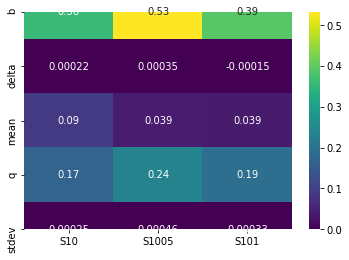

In [39]:
sns.heatmap(sobol_results_df[['S10', 'S1005', 'S101']], annot=True, cmap='viridis')

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


## Analysing using extra trees

In [64]:
n_scenarios = 1000

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model) as evaluator:
    results_lhs = evaluator.perform_experiments(n_scenarios, policy,
                                            uncertainty_sampling=LHS)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [65]:
experiments_lhs, outcomes_lhs = results_lhs

In [67]:
cleaned_experiments_lhs = experiments_lhs.drop(columns=[l.name for l in lake_model.levers])

In [83]:
scores_lhs = {}

for key in outcomes_lhs.keys():
    for policy in experiments_lhs.policy.unique():
        logical = experiments_lhs.policy == policy
        subset_results = {k:v[logical] for k,v in outcomes_lhs.items()}
        scores_lhs[policy] = feature_scoring.get_feature_scores_all(cleaned_experiments_lhs[logical], subset_results)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

In [71]:
cleaned_experiments_sobol = experiments_sobol.drop(columns=[l.name for l in lake_model.levers])

In [85]:
scores_sobol = {}

for key in outcomes_sobol.keys():
    for policy in experiments_sobol.policy.unique():
        logical = experiments_sobol.policy == policy
        subset_results = {k:v[logical] for k,v in outcomes_sobol.items()}
        scores_sobol[policy] = feature_scoring.get_feature_scores_all(cleaned_experiments_sobol[logical], subset_results)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

In [90]:
scores_lhs['0']

,max_P,utility,inertia,reliability
b,0.594404,0.0,0.0,0.446252
delta,0.055132,0.0,0.0,0.056652
mean,0.146867,0.0,0.0,0.187016
q,0.152404,0.0,0.0,0.255688
stdev,0.051192,0.0,0.0,0.054392


### Heat maps comparing all three policies using extra trees and Sobol

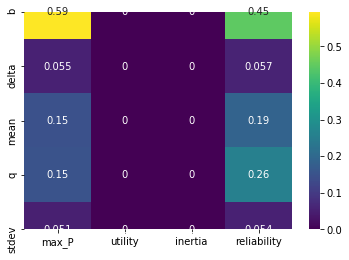

In [91]:
sns.heatmap(scores_lhs['0'], annot=True, cmap='viridis')
plt.show()

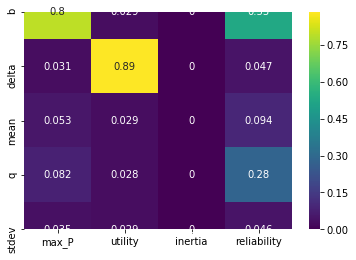

In [92]:
sns.heatmap(scores_lhs['0.05'], annot=True, cmap='viridis')
plt.show()

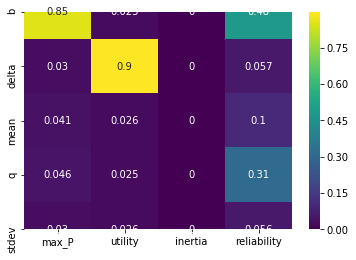

In [93]:
sns.heatmap(scores_lhs['0.1'], annot=True, cmap='viridis')
plt.show()

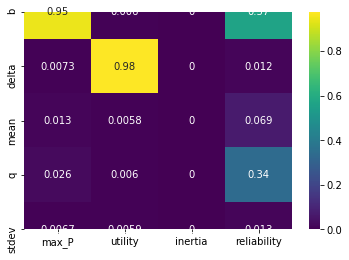

In [94]:
sns.heatmap(scores_sobol['0.1'], annot=True, cmap='viridis')
plt.show()